Impoort the necessary libaries

In [20]:
!pip install scikit-learn

In [21]:
import numpy
import numpy as np
import math
from scipy.stats import truncnorm
from sklearn import datasets as ds
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import StandardScaler

Create the Optimizer classes

In [22]:
class Optimizer:
    def __init__(self):
        return

    def optimize(self,w,learning_rate,dw):
        return

    '''
    Any initialization needed for dropouts
    '''
    def initialise_dropout(self,b_node_indices, node_indices):
        return

    '''
    Some optimizers need to be aware of any dropouts that may be taking place
    '''
    def dropout(self,back_active_node_indices, active_node_indices,dw):
        return

class GradientDescentOptimizer(Optimizer):
    def optimize(self,w,learning_rate,dw):
        #Update the weights
        w -= (learning_rate * dw)
        return w

class AdamOptimizer(Optimizer):
    def __init__(self, beta1=0.9,beta2=0.99):
        super().__init__()
        self.master_moment1 = np.array([0]).astype(float)
        self.master_moment2 = np.array([0]).astype(float)
        self.moment1 = np.array([0]).astype(float)
        self.moment2 = np.array([0]).astype(float)
        self.beta1 = beta1
        self.beta2 = beta2
        self.back_node_count = 0
        self.node_count = 0
        self.active_node_indices = np.array([0])
        self.moments_created = False

    def initialise_dropout(self,back_node_count, node_count):
        if self.moments_created==True: return
        self.moments_created = True
        self.back_node_count = back_node_count
        self.node_count = node_count
        self.active_node_indices = np.array(range(0, self.node_count))
        self.back_active_node_indices = np.array(range(0, self.back_node_count))
        self.master_moment1 = np.zeros([self.node_count,self.back_node_count]).astype(float)
        self.master_moment2 = np.zeros([self.node_count,self.back_node_count]).astype(float)

    def dropout(self,back_active_node_indices, active_node_indices,dw):
        self.back_active_node_indices = back_active_node_indices
        self.active_node_indices = active_node_indices
        self.moment1 = self.master_moment1[:, back_active_node_indices]
        self.moment1 = self.moment1[active_node_indices, :]
        self.moment2 = self.master_moment2[:, back_active_node_indices]
        self.moment2 = self.moment2[active_node_indices, :]


    def optimize(self,w,learning_rate,dw):
        #Calculate the value of the active moments. As we are implementing
        #dropout regularisation, we need to also drop out the corresponding
        #moments associated with each weight

        self.moment1 = self.beta1 * self.moment1 + (1 - self.beta1) * dw
        self.moment2 = self.beta2 * self.moment2 + (1 - self.beta2) * np.square(dw)



        #Update the master moments
        temp = self.master_moment1.copy()[:,self.back_active_node_indices]
        temp[self.active_node_indices] = self.moment1
        self.master_moment1[:, self.back_active_node_indices] = temp

        temp = self.master_moment2.copy()[:,self.back_active_node_indices]
        temp[self.active_node_indices] = self.moment2
        self.master_moment2[:, self.back_active_node_indices] = temp

        #Calculate the new weights
        w -= learning_rate * self.moment1 / (np.sqrt(self.moment2) + 1e-7)
        return w

Activation Function Classes. These allow for the implementation of Relu and Sigmoid

In [23]:
class ActivationFunction:
    def __init__(self,type):
        self.type = type

    def apply(self,x):
        return np.array([0])

    def derivative(self,x):
        return

class SigmoidActivation(ActivationFunction):
    def __init__(self):
        super().__init__("sigmoid")

    def apply(self,x):
        return 1.0/(1.0+np.exp(-x))

    def derivative(self,x):
        return self.apply(x) * (1.0 - self.apply(x))

class ReluActivation(ActivationFunction):
    def __init__(self):
        super().__init__("relu")

    def apply(self,x):
        return max(0,x)

    def derivative(self,x):
        return (x>=0) * 1 #From INM702 lab06_2 solution

class LinearActivation(ActivationFunction):
    def __init__(self,m,c):
        super().__init__("linear")
        self.m = m
        self.c = c

    def apply(self,x):
        return self.c+(self.m*x)

    def derivative(self,x):
        return (x*self.m)/self.m

class SoftmaxActivation(ActivationFunction):
    def __init__(self):
        super().__init__("softmax")

    def apply(self,x):
        x_shift = x - np.max(x)
        ex = np.exp(x_shift)
        return ex / ex.sum(axis=0, keepdims=True)

    def derivative(self,x):
        return None

The Layer classes. These represent Layers in the Neural Network. While not usually considered a layer in a Neural Network, an InputLayer class is created

In [24]:
class Layer:
    '''
    This is the base class for all layers in the neural network, including the input layer.
    While the input layer is not necessarily considered part of the layer count, we use this class
    to store the inputs as it is connected to the first hidden layer
    '''

    def __init__(self, layer_id: str, number_of_nodes: int):
        #All layers are active
        self.layer_id = layer_id
        self.number_of_nodes = number_of_nodes
        self.number_of_active_nodes = self.number_of_nodes
        self.output_original = np.empty([0]).astype(float)
        self.output = self.output_original
        self.biased_output = np.empty([0]).astype(float)
        self.active_node_indices = np.array(range(0,self.number_of_active_nodes))

    def describe(self):
        print("Layer ID:", self.layer_id, "\nNumber of Nodes:", self.number_of_nodes, ",Number of Active Nodes:", self.number_of_active_nodes)

    def addbias(self):
        #Add the bias
        bias = np.ones(self.output.shape[0])
        bias = bias.reshape(-1, 1)
        self.biased_output = np.append(self.output, bias, axis=1)

    def dropout(self,active_percent: float):
        self.number_of_active_nodes = int((1-(active_percent/100)) * self.number_of_nodes)
        self.active_node_indices = sorted(random.sample(range(0, self.number_of_nodes),self.number_of_active_nodes))
        if self.layer_id == "In": self.output = self.output_original[:,self.active_node_indices]
        return

    def reset_active_nodes(self):
        self.number_of_active_nodes = self.number_of_nodes
        self.active_node_indices = np.array(range(0, self.number_of_active_nodes))
        if self.layer_id == "In": self.output = self.output_original[:, self.active_node_indices]

class InputLayer(Layer):
    #This is used to store the sample data
    def __init__(self,layer_id: str, number_of_nodes: int):
        '''
        :param layer_id: An identified for this layer
        :param data: The sample data. Must be of the shape [number of samples,number of features].
                     The number of nodes in the input layer is given by the number of features
        '''
        super().__init__(layer_id, number_of_nodes) # for the bias

    def set_data(self,data: np.array):
        '''
        :param data: Array of shape [number of samples,number of features]
        :return:
        '''
        self.output_original = data
        self.output = self.output_original
        #Set the bias
        self.addbias()

class ActivationLayer(Layer):
    #This layer is used as the base for the Hidden and Output layers as they use
    #weights and activation functions
    def __init__(self, layer_id: str, number_of_nodes: int, activation_function: ActivationFunction, opti: Optimizer, learning_rate: float):
        super().__init__(layer_id, number_of_nodes) #for the bias
        #Initialise the partial derivatives
        self.d_l_a = np.array([0]).astype(float) #Derivative of loss wrt to activation
        self.d_a_z = np.array([0]).astype(float) #Derivative of activation
        self.d_z_w = np.array([0]).astype(float) #Derivative of z wrt to weights
        self.d_l_z = np.array([0]).astype(float) #Derivatie of loss wrt to z
        self.d_l_w = np.array([0]).astype(float) #Derivative of loss wrt to weights

        #Initialise the back layer
        self.back_layer = None
        self.front_layer = None

        #Set the activation function and learning rate
        self.activation_function = activation_function

        #Initialise the weights and store the learning rate
        self.master_weights = np.empty([0]).astype(float)
        self.active_weights = self.master_weights
        self.weighted_input = np.array([0]).astype(float)
        self.learning_rate = learning_rate

        #Initialise the arrays for logging the history of changes
        self.weight_history = np.empty([0]).astype(float)
        self.activation_history = np.empty([0]).astype(float)

        self.optimizer= opti

    def connect(self, back: Layer, front: Layer = None):
        #set the back layer
        self.back_layer = back
        self.front_layer = front
        return

    def create_weight_matrices(self):
        #Initialize the weight matrices of the neural network
        #This code was based on INM 702 (2022), Lab06_3, City, University of London
        #https://moodle.city.ac.uk/pluginfile.php/2974721/mod_folder/content/0/Lab06_3.ipynb?forcedownload=1
        np.random.seed(42)
        rad = 1 / np.sqrt(self.back_layer.number_of_nodes)
        mean=0
        sd=1
        low=-rad
        upp=rad
        w = truncnorm((low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
        self.master_weights = w.rvs((self.number_of_active_nodes, self.back_layer.number_of_active_nodes),random_state=42)
        self.active_weights = self.master_weights

    def update_weight_matrix(self):
        # Let's get the weight indices to dropout
        self.active_weights = self.master_weights[:, self.back_layer.active_node_indices]
        self.active_weights = self.active_weights[self.active_node_indices, :]

    def forward_propagate(self):
        #Apply the weights to the inputs
        self.weighted_input = np.dot(self.active_weights,self.back_layer.output.T)  # number_of_nodes x number_of_samples

        #Apply the activation function
        self.output = self.activation_function.apply(self.weighted_input)  # number_of_nodes x number of samples

        #Transpose so that our array shape is standard
        self.output = np.transpose(self.output)  # number of samples x number_of_nodes

        return

    def backward_propagate(self):
        return

    def update_weights(self):
        self.optimizer.initialise_dropout(self.back_layer.number_of_nodes,self.number_of_nodes)
        self.optimizer.dropout(self.back_layer.active_node_indices,self.active_node_indices,self.d_l_w)
        self.active_weights = self.optimizer.optimize(self.active_weights,self.learning_rate,self.d_l_w)
        #Update the weights
        #self.active_weights = self.active_weights - (self.learning_rate * self.d_l_w)  # number_of_active_nodes x number_active_nodes_back_layer
        # The next step is to update the master weights with their corresponding changes
        # in the active weights
        temp = self.master_weights.copy()[:,self.back_layer.active_node_indices]
        temp[self.active_node_indices] = self.active_weights
        self.master_weights[:, self.back_layer.active_node_indices] = temp
        return

    def reset_active_nodes(self):
        super().reset_active_nodes()
        self.active_weights = self.master_weights

    def delta_l_a(self):
        return self.d_l_a # number_of_samples x number of nodes

    def delta_a_z(self):
        return self.d_a_z # number_of_samples x number of nodes

    def delta_z_w(self):
        return self.d_z_w # number_of_samples x number_nodes_back_layer

    def delta_l_z(self):
        return self.d_l_z # number_of_samples x number of nodes

    def delta_z_a(self):
        return self.active_weights #number of nodes x number_nodes_back_layer

class HiddenLayer(ActivationLayer):
    def __init__(self, layer_id: str, number_of_nodes: int, activation_function: ActivationFunction,opti: Optimizer, learning_rate: float):
        super().__init__(layer_id,number_of_nodes,activation_function,opti,learning_rate)
        self.front_layer = None

    def describe(self):
        super().describe()
        print("Back Layer:",self.back_layer.layer_id, "Front Layer:", self.front_layer.layer_id)

    def forward_propagate(self):
        super().forward_propagate()

        #Uncomment the line below to use the bias
        #self.addbias()

    def backward_propagate(self):
        self.front_d_l_z = self.front_layer.delta_l_z()  # number of samples x number_nodes_front_layer
        self.front_d_z_a = self.front_layer.delta_z_a()  # number_nodes_front_layer x number_nodes
        # Get d_l_a
        self.d_l_a = np.dot(self.front_d_l_z, self.front_d_z_a)  # number_samples x number_of_nodes
        # Get d_a_z
        self.d_a_z = self.activation_function.derivative(self.weighted_input.T)  # number_of_samples x number_of_nodes
        # Get d_l_z
        self.d_l_z = self.d_l_a * self.d_a_z  # number_of_samples x number_of_nodes
        # Finally d_l_w, Note self.back_layer.forward_output = d_z_w
        self.d_l_w = np.dot(self.d_l_z.T, self.back_layer.output) #/ self.back_layer.output.shape[0]  # number_of_nodes x number_nodes_back_layer

class OutputLayer(ActivationLayer):
    def __init__(self, layer_id: str, number_of_nodes: int, activation_function: ActivationFunction,opti: Optimizer, learning_rate: float):
        super().__init__(layer_id,number_of_nodes,activation_function,opti,learning_rate)
        self.target = np.array([0]).astype(float)

    def describe(self):
        super().describe()
        print("Back Layer:",self.back_layer.layer_id)

    def set_target(self,target: np.array):
        self.target = target

    def back_propagate(self):
        if self.activation_function.type == "softmax":
            self.d_l_z = self.output - self.target  # number_of_samples x number_of_nodes
            # Get d_l_w = d_l_z . d_z_w. Note d_z_w = self.back_layer.forward_output
            self.d_l_w = np.dot(self.d_l_z.T, self.back_layer.output) #/ self.back_layer.output.shape[0]  # number_of_nodes x number_nodes_back_layer
        else:
            self.d_l_a = self.target - self.output  # number_of_samples x number_of_nodes
            self.d_a_z = self.activation_function.derivative(self.weighted_input.T)  # number_of_samples x number_of_nodes
            self.d_l_z = self.d_l_a * self.d_a_z  # number_of_samples x number_of_nodes
            self.d_z_w = self.back_layer.output  # number_of_samples x number_nodes_back_layer
            self.d_l_w = np.dot(self.d_l_z.T, self.d_z_w)  # number_of_nodes x number_nodes_back_layer
        return


Now the Neural Network class

In [29]:
class MyNeuralNetwork:

    '''
    Initialise all member variables in the constructor
    '''
    def __init__(self):
        #Stores the input layer
        self.input_layer = None

        #A numpy array for storing all the hidden layers
        self.hidden_layers = np.empty([0]).astype(HiddenLayer)

        #The output layer
        self.output_layer = None

        #An array for tracking the loss with each forward pass of the network
        self.loss_log = []

        #An array for tracking the accuracy with each forward pass of the network
        self.accuracy_log = []

    def describe(self):
        self.input_layer.describe()
        for l in self.hidden_layers:
            l.describe()
        self.output_layer.describe()

    def add_input(self,input_layer: InputLayer):
        '''
        Adds the input layer.
        :param input_layer: Input Layer object
        :return:
        '''
        self.input_layer = input_layer

    def add_output(self,output_layer: OutputLayer):
        self.output_layer = output_layer

    def add_hidden(self,hidden_layer: HiddenLayer):
        self.hidden_layers = np.append(self.hidden_layers,np.array([hidden_layer]), axis=0)

    def forward_propagate(self):
        for l in self.hidden_layers:
            l.forward_propagate()
        self.output_layer.forward_propagate()
        cost = -np.mean(self.output_layer.target * np.log(self.output_layer.output + 1e-8))
        return cost

    def backward_propagate(self):
        self.output_layer.back_propagate()
        for i in range(len(self.hidden_layers)-1,-1,-1):
            self.hidden_layers[i].backward_propagate()

        #After backpropagation we then update the active_weights
        self.output_layer.update_weights()
        for i in range(len(self.hidden_layers)-1,-1,-1):
            self.hidden_layers[i].update_weights()

    def dropout(self,dropout_percentage):
        self.input_layer.dropout(dropout_percentage)

        for i in range(len(self.hidden_layers)):
            self.hidden_layers[i].dropout(dropout_percentage)
            self.hidden_layers[i].update_weight_matrix()
        self.output_layer.update_weight_matrix()

    def reset_active_nodes(self):
        self.input_layer.reset_active_nodes()

        for i in range(len(self.hidden_layers)):
            self.hidden_layers[i].reset_active_nodes()

        self.output_layer.reset_active_nodes()

    def build(self):
        #Let's connect the layers together
        last_index = len(self.hidden_layers)-1
        #If this is only a 2 layer network i.e. 1 Hidden and 1 Output then connect them
        if last_index == 0:
            self.hidden_layers[last_index].connect(self.input_layer,self.output_layer)
            self.hidden_layers[last_index].create_weight_matrices()
        else:
            #There are multiple hidden so we iterate
            for i in range(len(self.hidden_layers)):
                # This is the first hidden layer so it's back layer is the input layer
                if i == 0 :
                    self.hidden_layers[i].connect(self.input_layer,self.hidden_layers[i+1])
                # This is the last hidden layer so it's front layer is the output layer
                elif i == last_index:
                    self.hidden_layers[i].connect(self.hidden_layers[i-1], self.output_layer)
                else:
                    self.hidden_layers[i].connect(self.hidden_layers[i - 1], self.hidden_layers[i+1])
                #Create the weight matrices
                self.hidden_layers[i].create_weight_matrices()

        #The last step is to connect the output layer to the last hidden
        self.output_layer.connect(self.hidden_layers[last_index])

        # Create the weight matrices
        self.output_layer.create_weight_matrices()

        return

    def train(self, X, y, dropout_rates, epochs):
        # This is where were train the model.
        # Set the data and target
        self.input_layer.set_data(X)
        self.output_layer.set_target(y)
        accuracy = 0

        #print("who:",self.output_layer.master_weights)
        for i in range(epochs):
            #At the start of each epoch we drop nodes
            self.dropout(dropout_rates[i])
            cost = self.forward_propagate()
            self.backward_propagate()
            self.reset_active_nodes()

            if i % 10 == 0:
                self.loss_log.append(cost)
                accuracy = self.get_accuracy(self.output_layer.output, y)
                self.accuracy_log.append(accuracy)

            if i % 100 == 0:
                print("Accuracy for epoch", epochs, ":", accuracy*100)

        return self.loss_log, self.accuracy_log

    def predict(self, X,y):
        # This is where were train the model.
        # Set the data and target
        self.input_layer.set_data(X)
        for l in self.hidden_layers:
            l.forward_propagate()
        self.output_layer.forward_propagate()
        y_pred = self.output_layer.output

        return self.get_accuracy(y_pred,y)

    '''
    Code for the get_accuracy came from 
    http://www.adeveloperdiary.com/data-science/deep-learning/neural-network-with-softmax-in-python/
    '''
    def get_accuracy(self,y_pred, y_target):
        y_hat = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_target, axis=1)
        accuracy = (y_hat == y_true).mean()
        return accuracy


Helper functions

In [30]:

def get_train_test():
    digits = ds.load_digits()
    X = digits.data
    y = digits.target


    onehot_encoder = OneHotEncoder(sparse_output=False)
    y = np.reshape(y, (-1, 1))
    y = onehot_encoder.fit_transform(y)
    y = np.array(y).astype(int)

    #We do a simple normalization of our data
    X = X / 255

    return train_test_split(X, y, test_size=0.20, random_state=42)

A simple test of the Neural Network

Accuracy for epoch 1000 : 10.160055671537926
Accuracy for epoch 1000 : 18.997912317327767
Accuracy for epoch 1000 : 21.781489213639528
Accuracy for epoch 1000 : 17.606123869171885
Accuracy for epoch 1000 : 38.20459290187891
Accuracy for epoch 1000 : 49.40848990953375
Accuracy for epoch 1000 : 54.27974947807933
Accuracy for epoch 1000 : 48.29505915100904
Accuracy for epoch 1000 : 56.36743215031316
Accuracy for epoch 1000 : 57.48086290883786
Accuracy for epoch 2000 : 10.090466249130133
Accuracy for epoch 2000 : 10.716771050800277
Accuracy for epoch 2000 : 12.734864300626306
Accuracy for epoch 2000 : 14.057063326374392
Accuracy for epoch 2000 : 30.410577592205986
Accuracy for epoch 2000 : 40.292275574112736
Accuracy for epoch 2000 : 54.83646485734168
Accuracy for epoch 2000 : 36.74321503131524
Accuracy for epoch 2000 : 61.02992345163535
Accuracy for epoch 2000 : 55.045233124565065
Accuracy for epoch 2000 : 43.77174669450243
Accuracy for epoch 2000 : 48.29505915100904
Accuracy for epoch 20

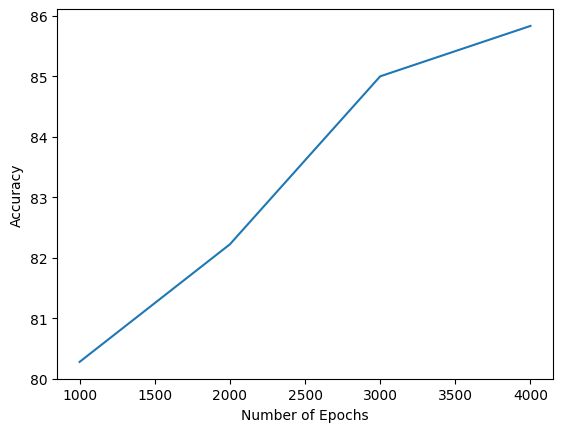

In [31]:
X_train, X_test, y_train, y_test = get_train_test()

learning_rate = 0.01
lower_drop_rate = 5
upper_drop_rate = 10 #This means no dropout

mynn = MyNeuralNetwork()
mynn.add_input(InputLayer("In",64))
mynn.add_hidden(HiddenLayer("H1",5,SigmoidActivation(),GradientDescentOptimizer(),learning_rate))
mynn.add_output(OutputLayer("Out1",10,SoftmaxActivation(),GradientDescentOptimizer(),learning_rate))


master_accuracy_log = np.empty((0,2),float)

for i in range(1000,5000,1000):
    mynn.build()
    epochs = i
    dropout_rates = np.random.randint(lower_drop_rate, upper_drop_rate, epochs)
    loss_log,accuracy_log = mynn.train(X_train,y_train,dropout_rates,epochs)
    accuracy = mynn.predict(X_test,y_test) * 100
    master_accuracy_log = np.append(master_accuracy_log,np.array([[epochs,accuracy]]),0)

# The next step is to show the loss
plt.figure()
#plt.plot(np.arange(len(loss_log)), loss_log,label="Loss")
plt.plot(master_accuracy_log[:,0], master_accuracy_log[:,1])
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.show()